In [1]:
%ls

drive/  sample_data/


In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 5437, done.
remote: Total 5437 (delta 0), reused 0 (delta 0), pack-reused 5437
Receiving objects: 100% (5437/5437), 8.05 MiB | 36.81 MiB/s, done.
Resolving deltas: 100% (3716/3716), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 645kB 18.5MB/s 
Setup complete. Using torch 1.8.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [4]:
# Export code snippet and paste here
%cd /content
%ls

/content
drive/  sample_data/  yolov5/


In [5]:
!curl -L "https://app.roboflow.com/ds/OGvY2Oa6vk?key=Qahed0GjDw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1986      0 --:--:-- --:--:-- --:--:--  1991
100 14.4M  100 14.4M    0     0  16.7M      0 --:--:-- --:--:-- --:--:--  158M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/103trolley_png.rf.8ff730cf2b30b06caa7b9b77d9ed7989.jpg  
 extracting: test/images/113trolley_png.rf.ce4a5e0e004316f687f4be74348497bb.jpg  
 extracting: test/images/117trolley_png.rf.248a9b8f4584d0e5cfdd60d160cbaf8a.jpg  
 extracting: test/images/125trolley_png.rf.899af5abdfb11d4e793a54fbedff44dc.jpg  
 extracting: test/images/128trolley_png.rf.839e455081b7d42420e1d4c1f4aac369.jpg  
 extracting: test/images/130trolley_png.rf.07c6b1c1a3bd811dfc0159962359a87e.jpg  
 extracting: test/images/146trolley_png.rf.ca5fb

In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['baggage']

In [7]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 2000 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

Streaming output truncated to the last 5000 lines.
     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 1001/1999     1.51G   0.01386   0.01049         0   0.02435        20       416: 100% 49/49 [00:07<00:00,  6.91it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:00<00:00,  8.06it/s]
                 all          78         119        0.99       0.874       0.956       0.821

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 1002/1999     1.51G   0.01365   0.01015         0    0.0238         8       416: 100% 49/49 [00:06<00:00,  7.34it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:00<00:00,  7.89it/s]
                 all          78         119        0.99       0.874       0.956       0.821

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 1003/1999     1.51G   0.0

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

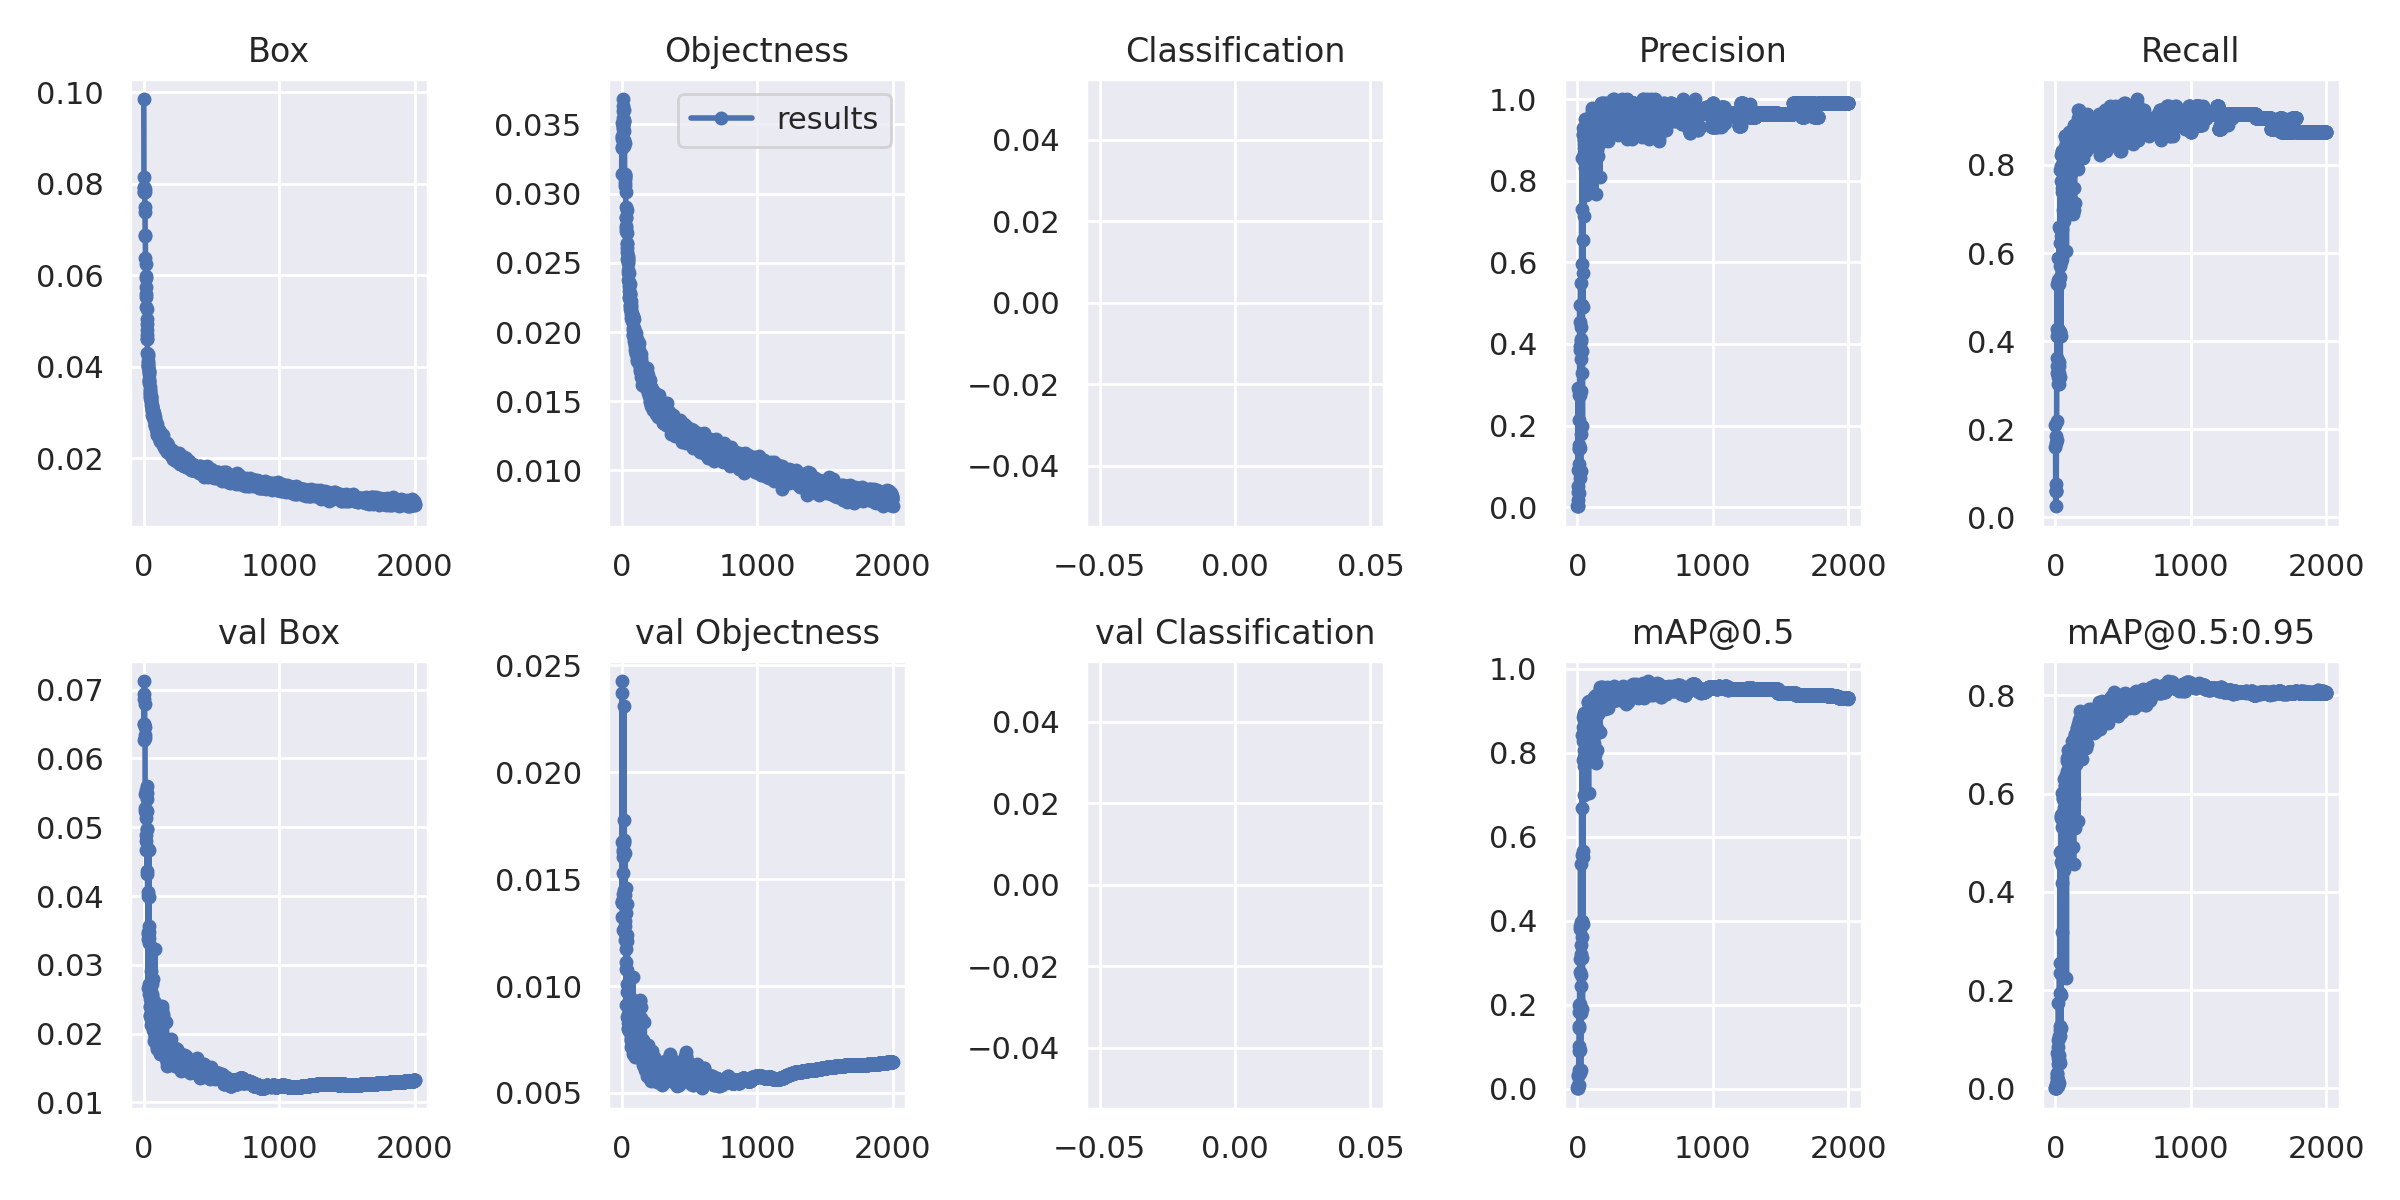

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


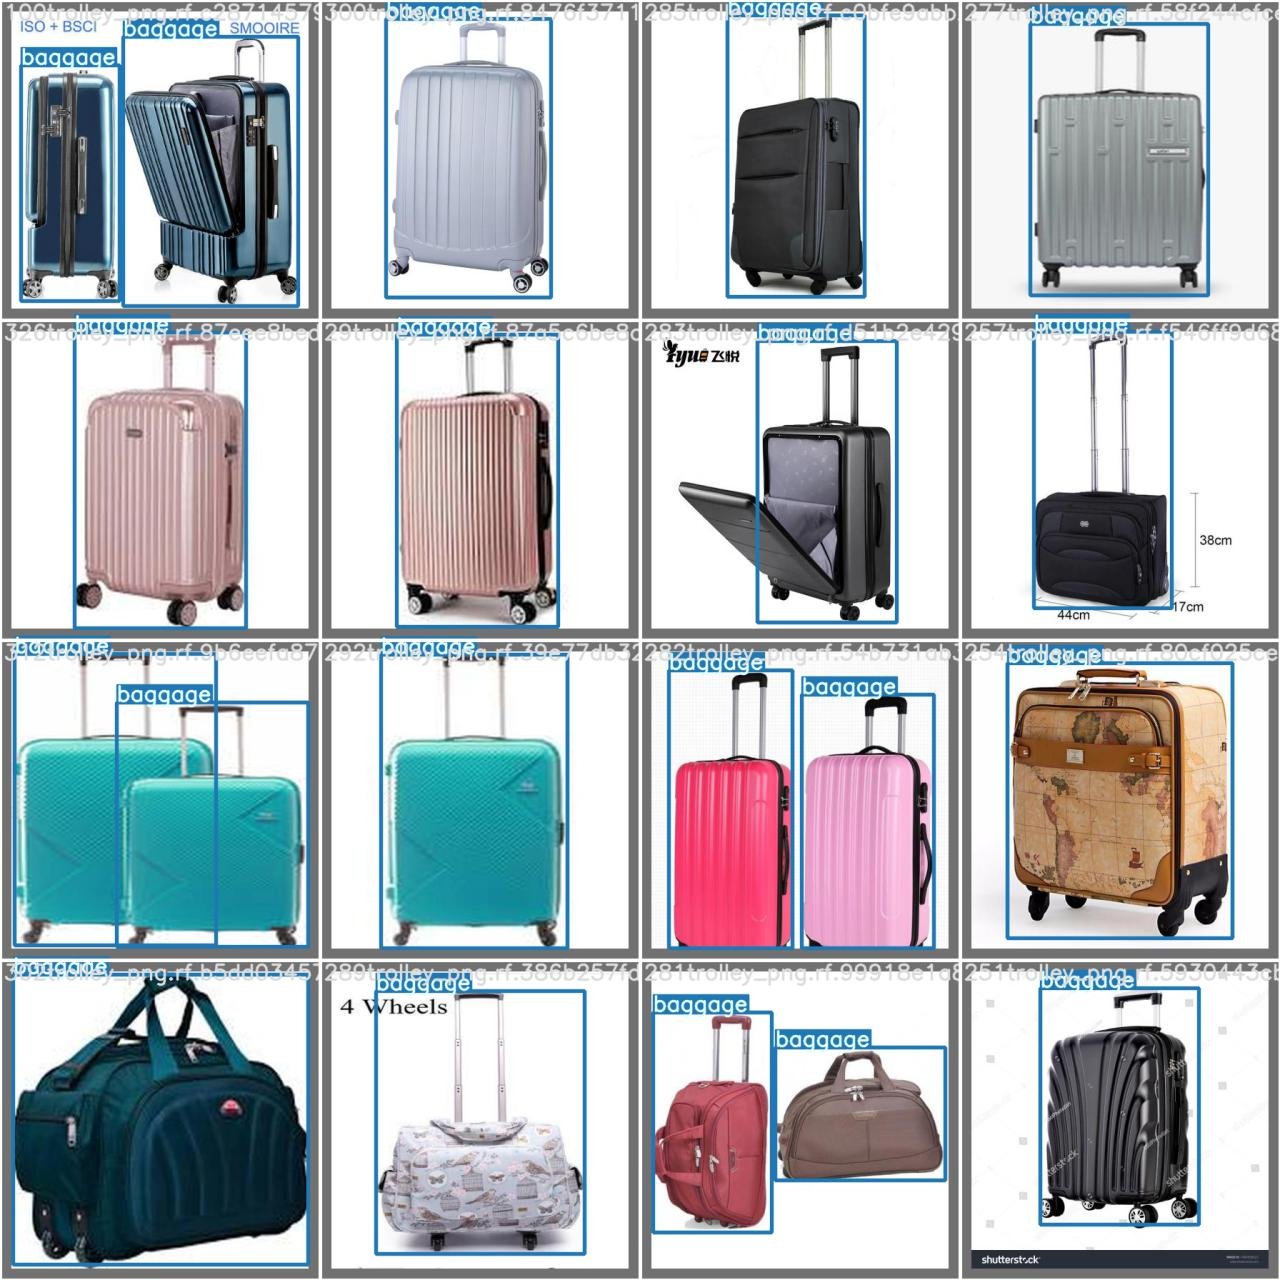

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


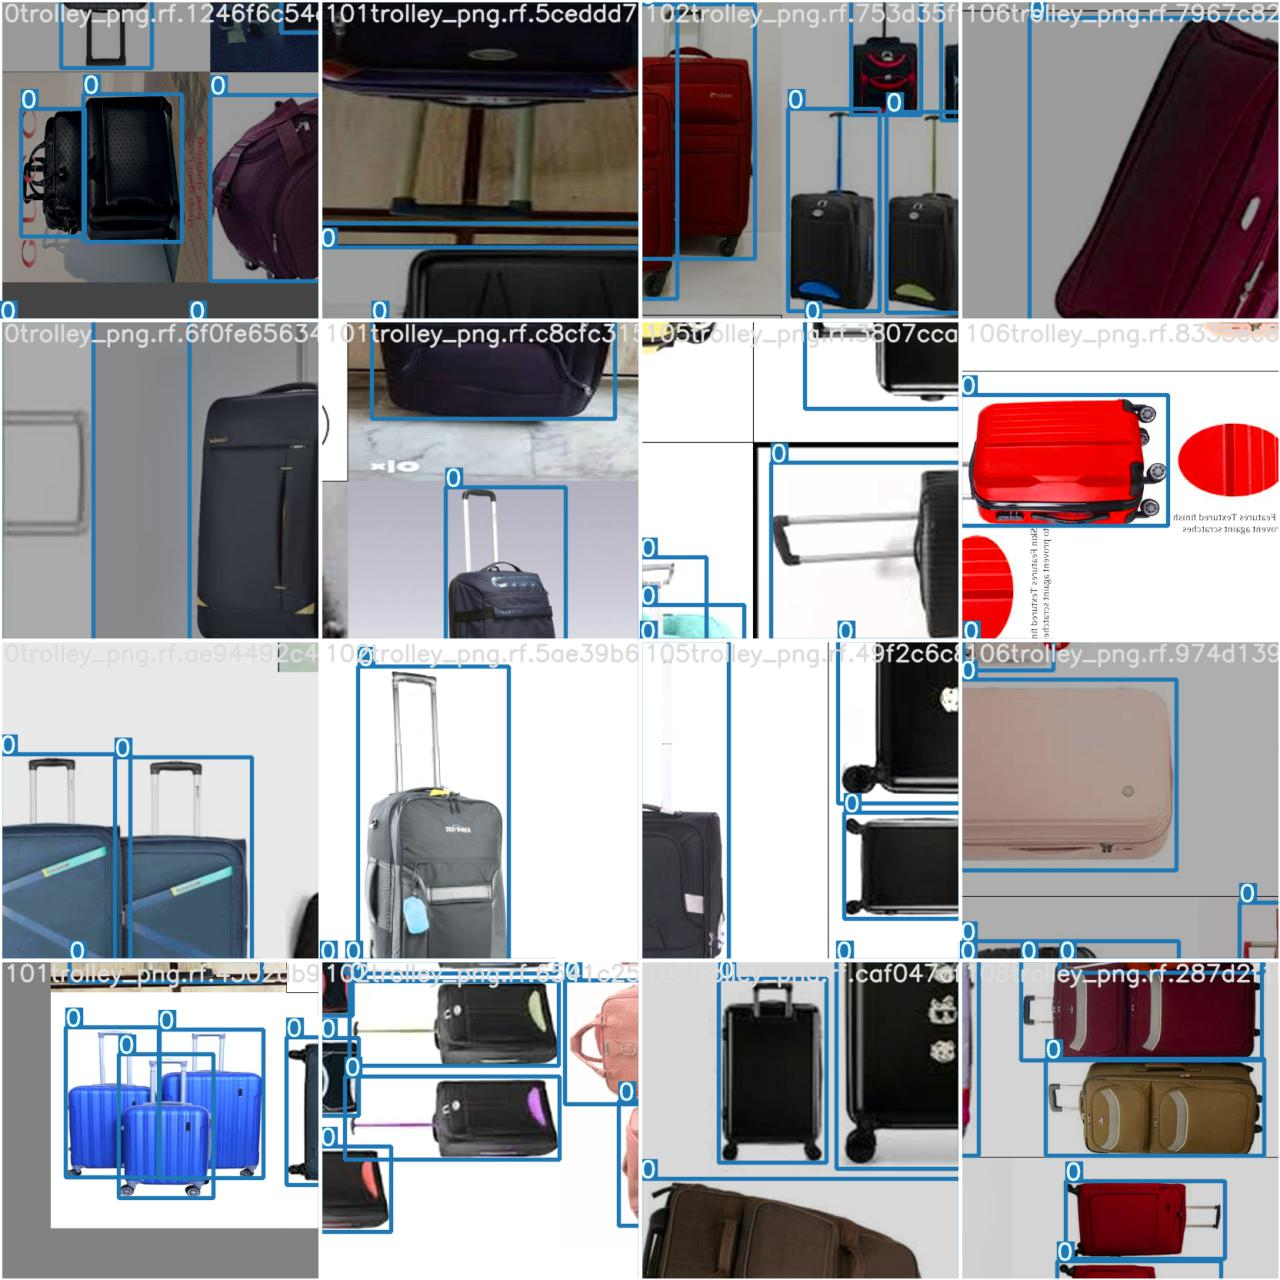

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPS
image 1/39 /content/yolov5/../test/images/103trolley_png.rf.8ff730cf2b30b06caa7b9b77d9ed7989.jpg: 416x416 5 baggages, Done. (0.011s)
image 2/39 /content/yolov5/../test/images/113trolley_png.rf.ce4a5e0e004316f687f4be74348497bb.jpg: 416x416 2 baggages, Done. (0.010s)
image 3/39 /content/yolov5/../test/images/117trolley_png.rf.248a9b8f4584d0e5cfdd60d160cbaf8a.jpg: 416x416 2 baggages, Done. (0.010s)
image 4/39 /content/yolov5/../test/images/125trolley_png.rf.899af5abdfb11d4e793a54fbedff44dc.jpg:

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/drive/My\ Drive

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
%ls

data/       hubconf.py  __pycache__/       runs/     tutorial.ipynb
detect.py   LICENSE     README.md*         test.py   utils/
Dockerfile  models/     requirements.txt*  train.py  weights/


In [ ]:
%cd /content/drive/My\ Drive/baggage\ detection/yolov5

/content/drive/My Drive/baggage detection/yolov5


In [ ]:
!python detect.py --source input1.mp4 --weights best_new.pt --conf 0.25

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='input1.mp4', update=False, view_img=False, weights=['best_new.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPS
video 1/1 (1/1051) /content/drive/My Drive/baggage detection/yolov5/input1.mp4: 384x640 Done. (0.011s)
video 1/1 (2/1051) /content/drive/My Drive/baggage detection/yolov5/input1.mp4: 384x640 Done. (0.010s)
video 1/1 (3/1051) /content/drive/My Drive/baggage detection/yolov5/input1.mp4: 384x640 Done. (0.010s)
video 1/1 (4/1051) /content/drive/My Drive/baggage detection/yolov5/input1.mp4: 384x640 Done. (0.013s)
video 1/1 (5/1051) /content/drive/My Drive/baggage detection/yolov5/input1.mp4: 384x640 Done. (0.011s)
video 1/1 (6/1051) /content/dri